In [96]:
import os
import glob
import sys
import getpass
import importlib
from tqdm import tqdm
from pathlib import Path

# user path:
usrname = getpass.getuser()
# add paths:
sys.path.append(f'/Users/{usrname}/Desktop/Projects')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/bimanual_wrist')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/Functional_Fusion')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/PcmPy')


import rsatoolbox as rsa
from rsatoolbox.io import spm as spm_io
import surfAnalysisPy as surf
import SUITPy as suit
import nibabel as nb
import nitools as nt
import PcmPy as pcm
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import seaborn as sns

import scipy.stats as stats
import scipy
import scipy.io as sio
import numpy as np
import pandas as pd

import utils
importlib.reload(utils)

# SET PATHS:
baseDir = os.path.join('/Users', getpass.getuser(), 'Desktop', 'Projects', 'bimanual_wrist', 'data', 'fMRI')
bidsDir = 'BIDS'
anatomicalDir = 'anatomicals'
freesurferDir = 'surfaceFreesurfer'
surfacewbDir = 'surfaceWB' 
behavDir = 'behavioural'
regDir = 'ROI'
atlasDir = '/Volumes/diedrichsen_data$/data/Atlas_templates/fs_LR_32'
analysisDir = os.path.join(os.path.dirname(os.path.dirname(baseDir)), 'analysis')



# Simulate Intrinsic

Make a feature model to generate dataset

Text(0.5, 1.0, 'True D')

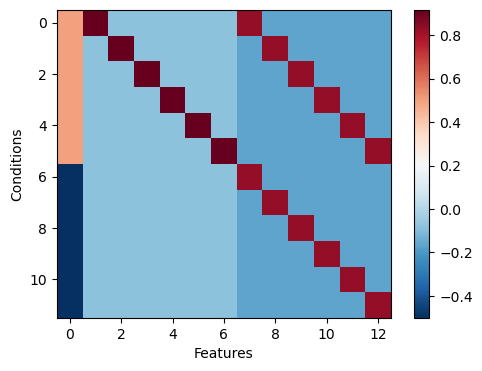

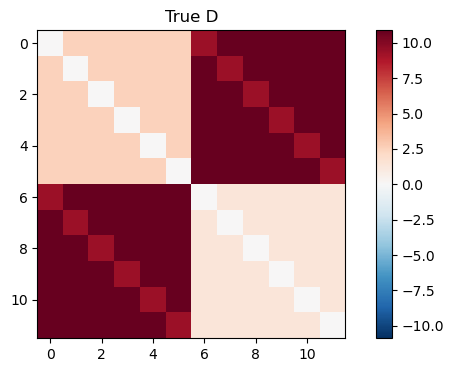

In [ ]:
# centering matrix:
C = pcm.matrix.centering(12)

# which hand reached:
F1 = np.zeros((12, 13))
F1[0:6, 0] = 1  # contra
F1[6: , 0] = 0  # ipsi
F1 = C @ F1

# Contralateral hand
F2 = np.zeros((12, 13))
F2[0:6, 1:7] = np.eye(6)
F2 = C @ F2

# Ipsilateral hand
F3 = np.zeros((12, 13))
F3[6: , 7:13] = np.eye(6)
F3 = C @ F3

# Intrinsic interaction:
F4 = np.zeros((12, 13))
F4[0:6, 7:13] = np.eye(6)
F4 = C @ F4

# Make feature model:
A = np.stack([F1, F2, F3, F4], axis=0)
M = pcm.model.FeatureModel('indep', A)

F = A.sum(axis=0)
plt.figure(figsize=(6,4))
plt.imshow(F, cmap='RdBu_r')
plt.colorbar()
plt.xlabel('Features')
plt.ylabel('Conditions')

theta_true = np.array([3, 0.5, 0.8, 1])
G_true, _ = M.predict(theta_true)
D_true = pcm.G_to_dist(G_true)
vmax = np.max(D_true)
vmin = -vmax
cmap = 'RdBu_r'
fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.imshow(D_true, cmap=cmap, vmin=vmin, vmax=vmax)
# color bar:
plt.colorbar(ScalarMappable(cmap=cmap, norm=mcolors.Normalize(vmin=vmin, vmax=vmax)), ax=ax)
ax.set_title('True D')





## simulate

/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Text(0.5, 1.0, 'True D')

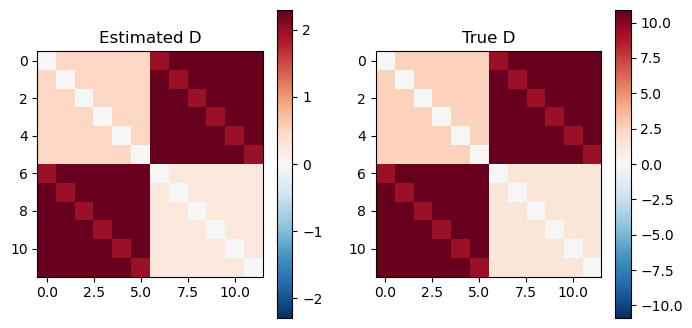

In [101]:
cond_vec, part_vec = pcm.sim.make_design(n_cond=12, n_part=10)
rng = np.random.default_rng(seed=100)
D = pcm.sim.make_dataset(model=M, 
    theta=theta_true, 
    cond_vec=cond_vec, 
    part_vec=part_vec, 
    n_sim=20, 
    signal=0.2,
    rng=rng)

# fit model:
T, theta = pcm.fit_model_individ(D, M, fixed_effect='block', fit_scale=True, verbose=False)
T_gr, theta_gr = pcm.fit_model_group(D, M, fixed_effect='block', fit_scale=True, verbose=False)
T_cv, theta_cv = pcm.fit_model_group_crossval(D, M, fixed_effect='block', fit_scale=True, verbose=False)

# estimated covariance matrix:
theta_est = theta_gr[0][0:4]
G_est, _ = M.predict(theta_est)
D_est = pcm.G_to_dist(G_est)
cmap = 'RdBu_r'

fig, ax = plt.subplots(1, 2, figsize=(8,4))
vmax = np.max(D_est)
vmin = -vmax
ax[0].imshow(D_est, cmap=cmap, vmin=vmin, vmax=vmax)
# color bar:
plt.colorbar(ScalarMappable(cmap=cmap, norm=mcolors.Normalize(vmin=vmin, vmax=vmax)), ax=ax[0])
ax[0].set_title('Estimated D')

vmax = np.max(D_true)
vmin = -vmax
ax[1].imshow(D_true, cmap=cmap, vmin=vmin, vmax=vmax)
# color bar:
plt.colorbar(ScalarMappable(cmap=cmap, norm=mcolors.Normalize(vmin=vmin, vmax=vmax)), ax=ax[1])
ax[1].set_title('True D')



# Simulate Extrinsic

make model

Text(0.5, 1.0, 'True D')

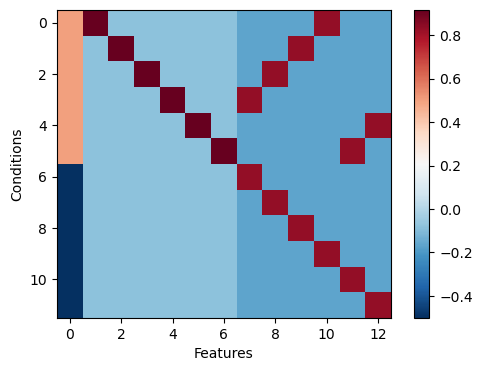

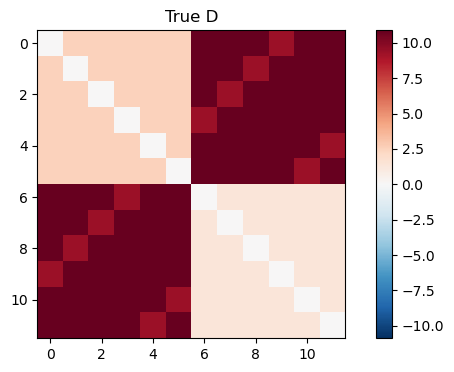

In [116]:
# centering matrix:
C = pcm.matrix.centering(12)

# which hand reached:
F1 = np.zeros((12, 13))
F1[0:6, 0] = 1  # contra
F1[6: , 0] = 0  # ipsi
F1 = C @ F1

# Contralateral hand
F2 = np.zeros((12, 13))
F2[0:6, 1:7] = np.eye(6)
F2 = C @ F2

# Ipsilateral hand
F3 = np.zeros((12, 13))
F3[6: , 7:13] = np.eye(6)
F3 = C @ F3

# Intrinsic interaction:
F4 = np.zeros((12, 13))
# F4[0:6, 7:13] = np.eye(6)
F4[0,10] = 1  # ipsi
F4[1,9] = 1
F4[2,8] = 1
F4[3,7] = 1
F4[4,12] = 1
F4[5,11] = 1
F4 = C @ F4

# Make feature model:
A = np.stack([F1, F2, F3, F4], axis=0)
M = pcm.model.FeatureModel('indep', A)

F = A.sum(axis=0)
plt.figure(figsize=(6,4))
plt.imshow(F, cmap='RdBu_r')
plt.colorbar()
plt.xlabel('Features')
plt.ylabel('Conditions')

theta_true = np.array([3, 0.5, 0.8, 1])
G_true, _ = M.predict(theta_true)
D_true = pcm.G_to_dist(G_true)
vmax = np.max(D_true)
vmin = -vmax
cmap = 'RdBu_r'
fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.imshow(D_true, cmap=cmap, vmin=vmin, vmax=vmax)
# color bar:
plt.colorbar(ScalarMappable(cmap=cmap, norm=mcolors.Normalize(vmin=vmin, vmax=vmax)), ax=ax)
ax.set_title('True D')



/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Text(0.5, 1.0, 'True D')

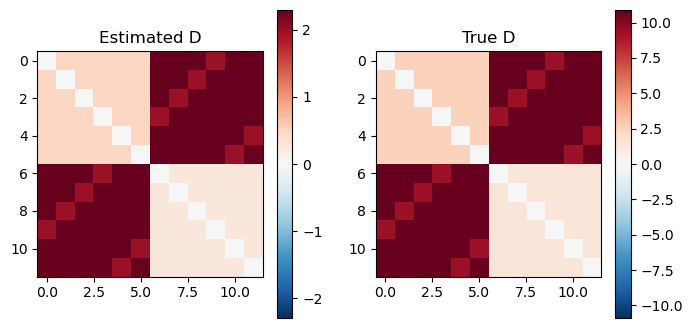

In [93]:
cond_vec, part_vec = pcm.sim.make_design(n_cond=12, n_part=10)
rng = np.random.default_rng(seed=100)
D = pcm.sim.make_dataset(model=M, 
    theta=theta_true, 
    cond_vec=cond_vec, 
    part_vec=part_vec, 
    n_sim=20, 
    signal=0.2,
    rng=rng)

# fit model:
T, theta = pcm.fit_model_individ(D, M, fixed_effect='block', fit_scale=True, verbose=False)
T_gr, theta_gr = pcm.fit_model_group(D, M, fixed_effect='block', fit_scale=True, verbose=False)
T_cv, theta_cv = pcm.fit_model_group_crossval(D, M, fixed_effect='block', fit_scale=True, verbose=False)

# estimated covariance matrix:
theta_est = theta_gr[0][0:4]
G_est, _ = M.predict(theta_est)
D_est = pcm.G_to_dist(G_est)
cmap = 'RdBu_r'

fig, ax = plt.subplots(1, 2, figsize=(8,4))
vmax = np.max(D_est)
vmin = -vmax
ax[0].imshow(D_est, cmap=cmap, vmin=vmin, vmax=vmax)
# color bar:
plt.colorbar(ScalarMappable(cmap=cmap, norm=mcolors.Normalize(vmin=vmin, vmax=vmax)), ax=ax[0])
ax[0].set_title('Estimated D')

vmax = np.max(D_true)
vmin = -vmax
ax[1].imshow(D_true, cmap=cmap, vmin=vmin, vmax=vmax)
# color bar:
plt.colorbar(ScalarMappable(cmap=cmap, norm=mcolors.Normalize(vmin=vmin, vmax=vmax)), ax=ax[1])
ax[1].set_title('True D')



# Simulate Intrinsic + Extrinsic

make the model

Text(0.5, 1.0, 'True D')

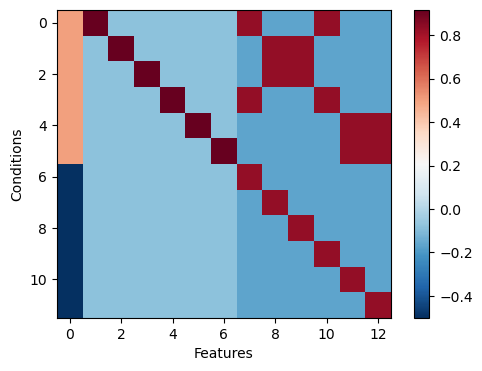

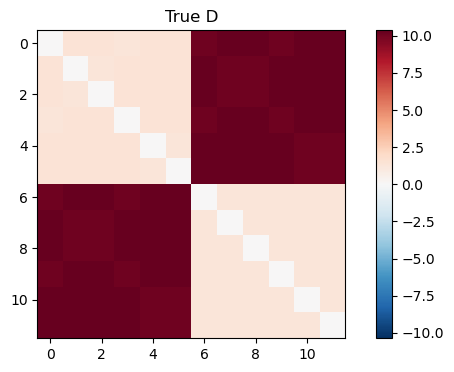

In [ ]:
# centering matrix:
C = pcm.matrix.centering(12)

# which hand reached:
F1 = np.zeros((12, 13))
F1[0:6, 0] = 1  # contra
F1[6: , 0] = 0  # ipsi
F1 = C @ F1

# Contralateral hand
F2 = np.zeros((12, 13))
F2[0:6, 1:7] = np.eye(6)
F2 = C @ F2

# Ipsilateral hand
F3 = np.zeros((12, 13))
F3[6: , 7:13] = np.eye(6)
F3 = C @ F3

# Extrinsic interaction:
F4 = np.zeros((12, 13))
# F4[0:6, 7:13] = np.eye(6)
F4[0,10] = 1  # ipsi
F4[1,9] = 1
F4[2,8] = 1
F4[3,7] = 1
F4[4,12] = 1
F4[5,11] = 1
F4 = C @ F4

# Intrinsic interaction:
F5 = np.zeros((12, 13))
F5[0:6, 7:13] = np.eye(6)

# Make feature model:
A = np.stack([F1, F2, F3, F4, F5], axis=0)
M = pcm.model.FeatureModel('indep', A)

F = A.sum(axis=0)
plt.figure(figsize=(6,4))
plt.imshow(F, cmap='RdBu_r')
plt.colorbar()
plt.xlabel('Features')
plt.ylabel('Conditions')

theta_true = np.array([3, 0.8, 0.8, 0.2, 0.2])
G_true, _ = M.predict(theta_true)
D_true = pcm.G_to_dist(G_true)
vmax = np.max(D_true)
vmin = -vmax
cmap = 'RdBu_r'
fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.imshow(D_true, cmap=cmap, vmin=vmin, vmax=vmax)
# color bar:
plt.colorbar(ScalarMappable(cmap=cmap, norm=mcolors.Normalize(vmin=vmin, vmax=vmax)), ax=ax)
ax.set_title('True D')




/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Text(0.5, 1.0, 'True D')

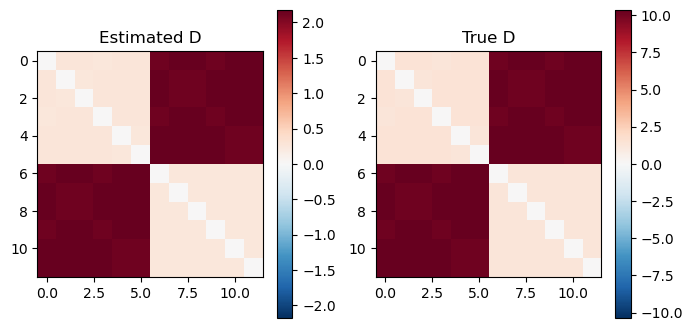

In [130]:
cond_vec, part_vec = pcm.sim.make_design(n_cond=12, n_part=10)
rng = np.random.default_rng(seed=100)
D = pcm.sim.make_dataset(model=M, 
    theta=theta_true, 
    cond_vec=cond_vec, 
    part_vec=part_vec, 
    n_sim=20, 
    signal=0.2,
    rng=rng)

# fit model:
T, theta = pcm.fit_model_individ(D, M, fixed_effect='block', fit_scale=True, verbose=False)
T_gr, theta_gr = pcm.fit_model_group(D, M, fixed_effect='block', fit_scale=True, verbose=False)
T_cv, theta_cv = pcm.fit_model_group_crossval(D, M, fixed_effect='block', fit_scale=True, verbose=False)

# estimated covariance matrix:
theta_est = theta_gr[0][0:5]
G_est, _ = M.predict(theta_est)
D_est = pcm.G_to_dist(G_est)
cmap = 'RdBu_r'

fig, ax = plt.subplots(1, 2, figsize=(8,4))
vmax = np.max(D_est)
vmin = -vmax
ax[0].imshow(D_est, cmap=cmap, vmin=vmin, vmax=vmax)
# color bar:
plt.colorbar(ScalarMappable(cmap=cmap, norm=mcolors.Normalize(vmin=vmin, vmax=vmax)), ax=ax[0])
ax[0].set_title('Estimated D')

vmax = np.max(D_true)
vmin = -vmax
ax[1].imshow(D_true, cmap=cmap, vmin=vmin, vmax=vmax)
# color bar:
plt.colorbar(ScalarMappable(cmap=cmap, norm=mcolors.Normalize(vmin=vmin, vmax=vmax)), ax=ax[1])
ax[1].set_title('True D')

